# SVM Classification with TF-IDF

This notebook demonstrates how to perform text classification using Support Vector Machines (SVM) and TF-IDF feature extraction.
Target Label: `Label`
Content: `Cleaned_Content`

Step 1: Loading Data...
Classes: ["Alzheimer's Disease" 'Frontotemporal Dementia' 'Lewy Body Dementia'
 "Parkinson's Disease" 'Vascular Dementia']
Step 2: Extracting TF-IDF Features...
Feature Matrix Shape: (800, 5000)

Step 3: Training SVM (Linear Kernel)...
Running 10-Fold Cross-Validation...
Mean CV Accuracy: 0.5338 (+/- 0.0387)

Step 4: Plotting Learning Curves...


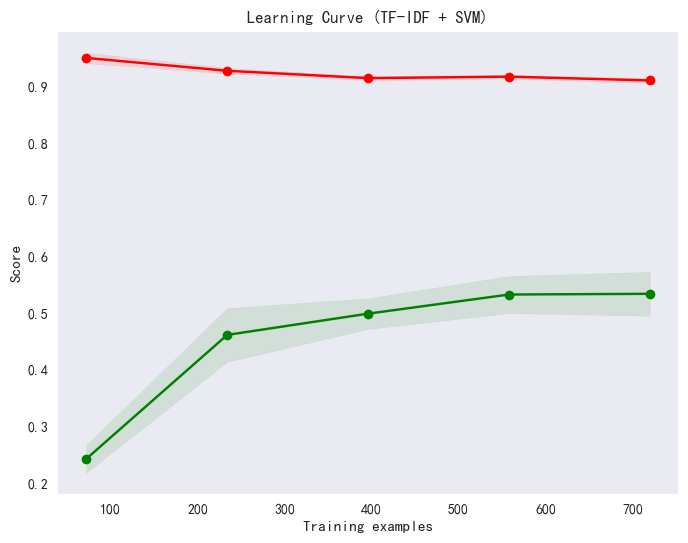


--- Classification Report ---
                         precision    recall  f1-score   support

    Alzheimer's Disease       0.64      0.68      0.66        40
Frontotemporal Dementia       0.53      0.68      0.59        40
     Lewy Body Dementia       0.53      0.47      0.50        40
    Parkinson's Disease       0.61      0.50      0.55        40
      Vascular Dementia       0.66      0.62      0.64        40

               accuracy                           0.59       200
              macro avg       0.59      0.59      0.59       200
           weighted avg       0.59      0.59      0.59       200



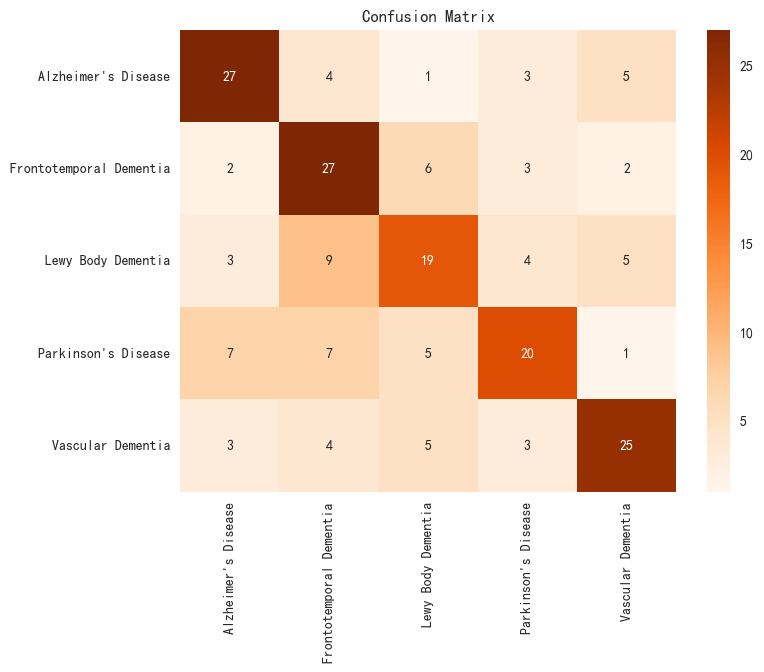

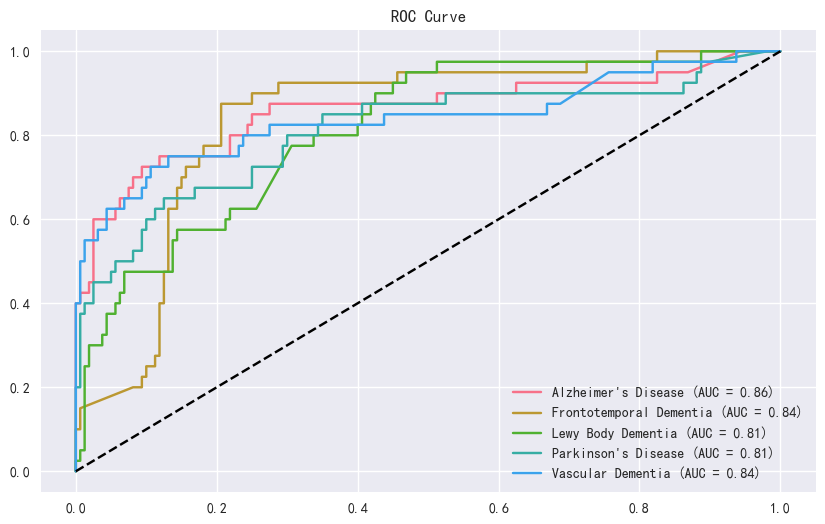


Step 6: Error Analysis...
Top Words in Errors: [('pad', np.int64(1368)), ('disease', np.int64(388)), ('study', np.int64(47)), ('patient', np.int64(45)), ('brain', np.int64(34)), ('cognitive', np.int64(31)), ('method', np.int64(24)), ('diagnosis', np.int64(21)), ('neurodegenerative', np.int64(21)), ('clinical', np.int64(19)), ('year', np.int64(19)), ('available', np.int64(17)), ('using', np.int64(17)), ('including', np.int64(16)), ('age', np.int64(15)), ('data', np.int64(15)), ('tau', np.int64(15)), ('body', np.int64(14)), ('intervention', np.int64(14)), ('related', np.int64(14))]

Step 7: SHAP Analysis (Linear Weights)...
SHAP Analysis skipped: The option feature_dependence has been renamed to feature_perturbation!


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, learning_curve
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
import shap
import warnings

# Ignore warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# ==========================================
# 1. 数据加载与预处理 (Data Loading)
# ==========================================
print("Step 1: Loading Data...")
try:
    df = pd.read_csv('../cleaned_data.csv')
except:
    df = pd.read_csv('cleaned_data.csv')

df['Cleaned_Content'] = df['Cleaned_Content'].fillna('')

le = LabelEncoder()
df['Label_Encoded'] = le.fit_transform(df['Label'])
label_names = le.classes_
print(f"Classes: {label_names}")

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    df['Cleaned_Content'], df['Label_Encoded'], 
    test_size=0.2, random_state=42, stratify=df['Label_Encoded']
)

# ==========================================
# 2. 特征工程: TF-IDF (Feature Engineering)
# ==========================================
print("Step 2: Extracting TF-IDF Features...")
# 使用 TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')

X_train_features = vectorizer.fit_transform(X_train_raw)
X_test_features = vectorizer.transform(X_test_raw)
feature_names = vectorizer.get_feature_names_out()

print(f"Feature Matrix Shape: {X_train_features.shape}")

# ==========================================
# 3. 模型训练: SVM (Training)
# ==========================================
print("\nStep 3: Training SVM (Linear Kernel)...")
# Probability=True needed for ROC and soft metrics
svm_model = SVC(kernel='linear', probability=True, random_state=42)

# 10-Fold CV
print("Running 10-Fold Cross-Validation...")
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = cross_val_score(svm_model, X_train_features, y_train, cv=cv, scoring='accuracy')

print(f"Mean CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

# Fit
svm_model.fit(X_train_features, y_train)

# ==========================================
# 4. 学习曲线 (Bias vs Variance)
# ==========================================
print("\nStep 4: Plotting Learning Curves...")
def plot_learning_curve(estimator, title, X, y, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(8, 6))
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.show()

plot_learning_curve(svm_model, "Learning Curve (TF-IDF + SVM)", X_train_features, y_train, cv=cv, n_jobs=-1)

# ==========================================
# 5. 评估与可视化 (Evaluation)
# ==========================================
y_pred = svm_model.predict(X_test_features)
y_prob = svm_model.predict_proba(X_test_features)

print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred, target_names=label_names))

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Oranges',
            xticklabels=label_names, yticklabels=label_names)
plt.title('Confusion Matrix')
plt.show()

plt.figure(figsize=(10, 6))
y_test_bin = pd.get_dummies(y_test).values
if y_test_bin.shape[1] == len(label_names):
    for i, class_label in enumerate(label_names):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{class_label} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

# ==========================================
# 6. 误差分析
# ==========================================
print("\nStep 6: Error Analysis...")
misclassified_indices = np.where(y_test != y_pred)[0]
# ... Standard Error Analysis Code ...
if len(misclassified_indices) > 0:
    error_docs = X_test_raw.iloc[misclassified_indices]
    from sklearn.feature_extraction.text import CountVectorizer
    error_cv = CountVectorizer(stop_words='english', max_features=20)
    try:
        error_counts = error_cv.fit_transform(error_docs)
        error_words = error_cv.get_feature_names_out()
        error_word_freq = np.asarray(error_counts.sum(axis=0)).flatten()
        print(f"Top Words in Errors: {sorted(dict(zip(error_words, error_word_freq)).items(), key=lambda x: x[1], reverse=True)}")
    except: pass

# ==========================================
# 7. 可解释性 SHAP (Explainability)
# ==========================================
print("\nStep 7: SHAP Analysis (Linear Weights)...")
try:
    # LinearExplainer for Linear SVM
    # Need to pass the summary of background data (masker) for speed, or full train data
    sample_train = shap.sample(X_train_features, 100)
    explainer = shap.LinearExplainer(svm_model, sample_train, feature_dependence="independent")
    
    sample_test = X_test_features[:100].toarray() # LinearExplainer prefers dense often, or sparse
    shap_values = explainer.shap_values(sample_test)
    
    print("SHAP Summary Plot")
    shap.summary_plot(shap_values, sample_test, feature_names=feature_names, show=False)
    plt.show()
except Exception as e:
    print(f"SHAP Analysis skipped: {e}")